## This is the first notebook done after the hackathon
### I'm using a different approach to calculating features (more array and vector based and less row and loop based) which is speeding up the calculation. 
### The thought process is the same
#### - Justin

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import math
welly.__version__

'0.3.5'

In [2]:
%%timeit
import os
env = %env


86.6 µs ± 966 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [3]:
from IPython.display import display

In [4]:
#### Test results Part 1
#### Had to change display options to get this to print in full!
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100000

OptionError: "No such keys(s): 'display.height'"

## We're going to load a pickle file of a previously created dataframe

### The dataframe merges:
1. picks_dic = pd.read_csv('../../SPE_006_originalData/OilSandsDB/PICKS_DIC.TXT',delimiter='\t')
2. picks = pd.read_csv('../../SPE_006_originalData/OilSandsDB/PICKS.TXT',delimiter='\t')
3. wells = pd.read_csv('../../SPE_006_originalData/OilSandsDB/WELLS.TXT',delimiter='\t')
4. gis = pd.read_csv('../../well_lat_lng.csv')

### It also excludes any wells that have nulls or zeros for Top McMurray or Base McMurray picks
This was done in notebooks: 
1. notebooks_2018/mapmaking/Map_Exploration_v2-KDtree.ipynb
2. notebooks_2018/Test_RUN_2018_02/DataCleaningPrepof_KNN_neighborPickDepth_df_creation_vA_20180210

### Let's load in the pickle file of the dataframe from previous notebook mentioned above

In [6]:
wells_df_new_cleaned_plus_nn_wNoNulls =  pd.read_pickle('wells_df_new_cleaned_plus_nn_wNoNulls.p')

In [7]:
wells_df_new_cleaned_plus_nn_wNoNulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1921 entries, 0 to 2192
Data columns (total 16 columns):
SitID                                  1921 non-null int64
McMurray_Base_HorID                    1921 non-null int64
McMurray_Top_HorID                     1921 non-null int64
McMurray_Base_DEPTH                    1921 non-null float64
McMurray_Top_DEPTH                     1921 non-null float64
McMurray_Base_Qual                     1921 non-null int64
McMurray_Top_Qual                      1921 non-null int64
lat                                    1921 non-null float64
lng                                    1921 non-null float64
UWI                                    1921 non-null object
Neighbors_Obj                          1921 non-null object
NN1_McMurray_Top_DEPTH                 1921 non-null float64
NN1_McMurray_Base_DEPTH                1921 non-null float64
NN1_thickness                          1921 non-null float64
MM_Top_Depth_predBy_NN1thick           1921 non-nul

In [8]:
wells_df_new_cleaned_plus_nn_wNoNulls.head()

SitID  McMurray_Base_HorID  McMurray_Top_HorID  McMurray_Base_DEPTH  \
0  102496                14000               13000                561.0   
1  102497                14000               13000                604.5   
2  102498                14000               13000                564.0   
3  102500                14000               13000                636.5   
4  102501                14000               13000                613.0   

   McMurray_Top_DEPTH  McMurray_Base_Qual  McMurray_Top_Qual        lat  \
0               475.0                   1                  3  54.785907   
1               515.0                   1                  3  54.782284   
2               480.0                   1                  3  54.785892   
3               549.0                   1                  3  54.829624   
4               529.0                   1                  2  54.840471   

          lng                  UWI  \
0 -110.129320  00/12-08-067-01W4/0   
1 -110.269446  00/07-08-067-02W4/0   
2 -110.186851  00/09-11-067-02W4/0   
3 -110.269422  00/10-29-067-02W4/0   
4 -110.224832  00/06-34-067-02W4/0   

                                       Neighbors_Obj  NN1_McMurray_Top_DEPTH  \
0  [{'distance': 0.05753100195547899, 'neighbor':...                   544.0   
1  [{'distance': 0.04734000608365529, 'neighbor':...                   529.0   
2  [{'distance': 0.05753100195547899, 'neighbor':...                   529.0   
3  [{'distance': 0.04355700607250212, 'neighbor':...                   529.0   
4  [{'distance': 0.04589036401030715, 'neighbor':...                   514.0   

   NN1_McMurray_Base_DEPTH  NN1_thickness  MM_Top_Depth_predBy_NN1thick  \
0                    630.0           86.0                         475.0   
1                    613.0           84.0                         520.5   
2                    613.0           84.0                         480.0   
3                    613.0           84.0                         552.5   
4                    603.0           89.0                         524.0   

   MM_Top_Depth_Real_v_predBy_NN1thick  
0                                  0.0  
1                                 -5.5  
2                                  0.0  
3                                 -3.5  
4                                  5.0

In [9]:
print(len(wells_df_new_cleaned_plus_nn_wNoNulls))

1921


In [10]:
wells_df_new_cleaned_plus_nn_wNoNulls.head()

SitID  McMurray_Base_HorID  McMurray_Top_HorID  McMurray_Base_DEPTH  \
0  102496                14000               13000                561.0   
1  102497                14000               13000                604.5   
2  102498                14000               13000                564.0   
3  102500                14000               13000                636.5   
4  102501                14000               13000                613.0   

   McMurray_Top_DEPTH  McMurray_Base_Qual  McMurray_Top_Qual        lat  \
0               475.0                   1                  3  54.785907   
1               515.0                   1                  3  54.782284   
2               480.0                   1                  3  54.785892   
3               549.0                   1                  3  54.829624   
4               529.0                   1                  2  54.840471   

          lng                  UWI  \
0 -110.129320  00/12-08-067-01W4/0   
1 -110.269446  00/07-08-067-02W4/0   
2 -110.186851  00/09-11-067-02W4/0   
3 -110.269422  00/10-29-067-02W4/0   
4 -110.224832  00/06-34-067-02W4/0   

                                       Neighbors_Obj  NN1_McMurray_Top_DEPTH  \
0  [{'distance': 0.05753100195547899, 'neighbor':...                   544.0   
1  [{'distance': 0.04734000608365529, 'neighbor':...                   529.0   
2  [{'distance': 0.05753100195547899, 'neighbor':...                   529.0   
3  [{'distance': 0.04355700607250212, 'neighbor':...                   529.0   
4  [{'distance': 0.04589036401030715, 'neighbor':...                   514.0   

   NN1_McMurray_Base_DEPTH  NN1_thickness  MM_Top_Depth_predBy_NN1thick  \
0                    630.0           86.0                         475.0   
1                    613.0           84.0                         520.5   
2                    613.0           84.0                         480.0   
3                    613.0           84.0                         552.5   
4                    603.0           89.0                         524.0   

   MM_Top_Depth_Real_v_predBy_NN1thick  
0                                  0.0  
1                                 -5.5  
2                                  0.0  
3                                 -3.5  
4                                  5.0

In [11]:
df_new = wells_df_new_cleaned_plus_nn_wNoNulls
# df_new["UWI (AGS)"] = df_new["UWI (AGS)_x"]
df_new["UWI"] = df_new["UWI"]
df_new["HorID"] = df_new["McMurray_Top_HorID"]
df_new["Pick"] = df_new["McMurray_Top_DEPTH"]
df_new["Quality"] = df_new["McMurray_Top_Qual"]
df_new["HorID_paleoz"] = df_new["McMurray_Base_HorID"]
df_new["Pick_paleoz"] = df_new["McMurray_Base_DEPTH"]
df_new["Quality_paleoz"] = df_new["McMurray_Base_Qual"]
df_new = df_new[["SitID","UWI","HorID","Pick","Quality","HorID_paleoz","Pick_paleoz","Quality_paleoz",'lat','lng','MM_Top_Depth_predBy_NN1thick','NN1_thickness']]
df_new

SitID                  UWI  HorID    Pick  Quality  HorID_paleoz  \
0     102496  00/12-08-067-01W4/0  13000  475.00        3         14000   
1     102497  00/07-08-067-02W4/0  13000  515.00        3         14000   
2     102498  00/09-11-067-02W4/0  13000  480.00        3         14000   
3     102500  00/10-29-067-02W4/0  13000  549.00        3         14000   
4     102501  00/06-34-067-02W4/0  13000  529.00        2         14000   
5     102503  00/11-04-067-03W4/0  13000  488.50        2         14000   
6     102505  00/10-08-067-03W4/0  13000  501.50        2         14000   
7     102507  00/10-14-067-03W4/0  13000  553.50        2         14000   
8     102514  00/10-28-067-03W4/0  13000  493.50        3         14000   
9     102517  00/07-36-067-03W4/0  13000  536.50        2         14000   
10    102518  00/10-02-067-04W4/0  13000  528.00        1         14000   
11    102565  00/10-07-067-04W4/0  13000  514.00        1         14000   
12    102577  00/11-24-067-04W4/0  13000  487.50        1         14000   
13    102581  00/07-33-067-04W4/0  13000  509.00        1         14000   
14    102583  00/13-03-067-05W4/0  13000  487.00        2         14000   
15    102589  00/06-16-067-05W4/0  13000  486.00        1         14000   
16    102592  00/07-25-067-05W4/0  13000  490.50        1         14000   
17    102596  00/10-33-067-05W4/0  13000  481.00        1         14000   
18    102597  00/15-01-067-06W4/0  13000  503.00        2         14000   
19    102606  00/06-17-067-06W4/0  13000  492.00        3         14000   
20    141727  00/07-23-067-06W4/0  13000  484.00        2         14000   
21    102609  00/02-29-067-06W4/0  13000  493.00        2         14000   
22    102610  00/11-05-067-07W4/0  13000  473.00        1         14000   
23    102611  00/06-13-067-07W4/0  13000  493.00        2         14000   
24    102614  00/03-25-067-07W4/0  13000  487.00        1         14000   
25    102615  00/08-29-067-07W4/0  13000  526.00        3         14000   
26    102619  00/10-03-067-08W4/0  13000  469.00        1         14000   
27    102620  00/06-13-067-08W4/0  13000  494.00        1         14000   
28    141732  00/10-29-067-08W4/0  13000  489.00        1         14000   
29    102626  00/07-34-067-08W4/0  13000  497.00        1         14000   
...      ...                  ...    ...     ...      ...           ...   
2162  126060  AA/07-29-099-12W4/0  13000  364.00        3         14000   
2164  126063  AA/11-16-099-13W4/0  13000  560.83        2         14000   
2165  126064  AA/09-23-099-13W4/0  13000  569.50        1         14000   
2166  126066  AA/16-34-099-13W4/0  13000  522.43        3         14000   
2167  126068  AA/07-09-099-14W4/0  13000  520.00        1         14000   
2168  126069  AA/11-22-099-14W4/0  13000  545.50        2         14000   
2169  126070  AA/11-24-099-14W4/0  13000  538.00        2         14000   
2170  126071  AA/02-29-099-14W4/0  13000  530.50        2         14000   
2171  126073  AA/11-09-099-15W4/0  13000  437.00        1         14000   
2172  126074  AA/12-12-099-15W4/0  13000  463.00        3         14000   
2173  126076  AA/11-26-099-15W4/0  13000  450.00        3         14000   
2174  126151  AA/11-29-100-12W4/0  13000  508.50        2         14000   
2175  126152  AA/09-06-100-13W4/0  13000  525.00        2         14000   
2176  126154  AA/11-13-100-13W4/0  13000  530.50        2         14000   
2177  126156  AA/01-22-100-13W4/0  13000  498.04        2         14000   
2178  126157  AA/14-35-100-13W4/0  13000  513.28        3         14000   
2179  126160  AA/06-16-100-14W4/0  13000  452.63        3         14000   
2180  126161  AA/10-29-100-14W4/0  13000  455.00        1         14000   
2181  126162  AA/09-35-100-14W4/0  13000  467.26        3         14000   
2182  126231  AA/07-08-101-12W4/0  13000  561.00        1         14000   
2183  126234  AA/06-31-101-12W4/0  13000  515.00        1         14000   
2184  126235  AA/01-05-101-13W4/

In [12]:
print(len(df_new))

1921


In [13]:
#### Number of unique wells based on UWI
len(df_new.UWI.unique())

1921

In [14]:
df_new_test = df_new[['UWI']]

In [15]:
print(any(df_new_test.UWI == '00/11-04-067-03W4/0'))

True


## Brainstorm 1 : various features to extract
1. Find average values of [each curve] in [different] length windows [above, around, below] a depth
2. Find average for [different number of] [max, min] values in [different] length windows [above, around, below] a depth for [each curve]
3. Find gradient within [window length] around a depth point 
4. Find [min, avg, max] gradient of various [smaller window length] within a larger [larger window length]
5. Find number of gradient changes (negative to positive) of various [smaller window length] within a larger [larger window length]
6. Find difference between two windows on either side of a given depth. For each window, average for [different number of] [max, min] values in [different] length windows above & below a given depth for [each curve].

In [16]:
####
def addColWindowMean(df,col,windowSize,centered):
    featureName = col+"_mean_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).mean() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).mean() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).mean() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [17]:
####
def addColWindowMax(df,col,windowSize,centered):
    featureName = col+"_max_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).max() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).max() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).max() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [18]:
#### Returns a column with the min values of a window centered 
def addColWindowMin(df,col,windowSize,centered):
    featureName = col+"_min_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).min() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).min() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).min() 
        #### unreverse
        
        df = df.sort_index(ascending=True)
    return df

In [19]:
#### helper function that takes in array and an integer for the number of highest values to find the mean of 
#### example: for an array = [1,3,6,44,33,22,452] and nValues = 2, the answer would be 44+452 / 2
def nLargest(array,nValues):
    answer = np.mean(array[np.argsort(array)[-nValues:]])  
    return answer

In [20]:
#### Returns a column with the average of the N largest values of a window 
def addColWindowAvgMaxNvalues(df,col,windowSize,centered,nValues):
    #df[featureName] = df[col].rolling(center=True,window=windowSize).nlargest(nValues).mean() 
    #return df
    featureName = col+"_min_"+str(windowSize)+"winSize_"+"dir"+centered+"_n"+str(nValues)
    if(centered == "around"):
        #df[featureName] = df[col].rolling(center=True,window=windowSize).nlargest(nValues).mean() 
        df[featureName] = df[col].rolling(center=True,window=windowSize).apply(lambda x: nLargest(x,nValues))
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).apply(lambda x: nLargest(x,nValues))
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        #   # df['new_column'] = df.apply(lambda x: your_function(x['High'],x['Low'],x['Close']), axis=1)
        df[featureName] = df[col].rolling(center=False,window=windowSize).apply(lambda x: nLargest(x,nValues))
        #df[featureName] = df[col].rolling(center=False,window=windowSize).nlargest(nValues).mean() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [21]:
#### Takes MM_Top_Depth_predBy_NN1thick and subtracts depth at that point, returns value
def NN1_TopMcMDepth(df,MM_Top_Depth_predBy_NN1thick):
    df['DistFrom_NN1_TopDepth'] = df[MM_Top_Depth_predBy_NN1thick] - df['DEPT'] 
    return df


In [22]:
#### Takes MM_Top_Depth_predBy_NN1thick and subtracts depth at that point, returns *absolute* value
def NN1_TopMcMDepth_Abs(df,MM_Top_Depth_predBy_NN1thick):
    df['DistFrom_NN1_TopDepth_Abs'] = math.fabs(df[MM_Top_Depth_predBy_NN1thick] - df['DEPT'])
    return df

In [23]:
####
winVars = {"RangeOfCurves":['GR'],
                   "RangeOfWindows":[5,11,29],
                   "RangeOfWindowsCaution":[5],
                   "RangeOfDirection":['above','below','around'],
                   "MinOrMaxRange":['min','max'],
                   "NumbPtsRange":[1,5]}

## Read in well logs from LAS files and put into Dictionary of Dataframes. As Reading-in, add features

In [24]:
def loadAndAddFeatures():
    count=0
    data_df=[]
    count_limit =1663
    list_of_failed_wells = []
    ### dictionary that holds every well as key:value or "UWI":df pair
    df_w_dict ={}
    while count < count_limit:
        for file in glob.glob('../../SPE_006_originalData/OilSandsDB/Logs/*.LAS'):
            #### NOTE: limiting wells being read-in to 101 here !!!!!!!!!!!!!!!!
            count+=1
            if count > count_limit:
                print("hit limit of count below file for loop")
                answer = [df_w_dict,list_of_failed_wells]
                return answer
            else:
                l_df = lasio.read(file).df()
                #print(l_df)
                str_uwi= file[-23:-4].replace("-", "/",1)[:17]+file[-6:-4].replace("-", "/",1)
                #l_df.DEPT = l_df.DEPT.astype(float)
                ##bottom_well_depth = l_df['DEPT'].max()
                if any(df_new.UWI == str_uwi):
                    if df_new[df_new['UWI']==str_uwi]['Quality'].iloc[0] > -1:
                        l_df = l_df.reset_index()
                        print("got to UWI apppend")
                        l_df['UWI'] = str_uwi
                        print("UWI added is ",str_uwi," and type is ",type(str_uwi))
                        l_df['SitID']=df_new[df_new['UWI']==str_uwi]['SitID'].iloc[0]
#                         l_df['UWI (AGS)']=df_new[df_new['UWI']==str_uwi]['UWI (AGS)'].iloc[0]
                        l_df['Pick']=df_new[df_new['UWI']==str_uwi]['Pick'].iloc[0] 
                        l_df['HorID']=df_new[df_new['UWI']==str_uwi]['HorID'].iloc[0]
                        l_df['Quality']=df_new[df_new['UWI']==str_uwi]['Quality'].iloc[0]
                        #### adding in paleozoic surface pick
                        l_df['Pick_paleoz']=df_new[df_new['UWI']==str_uwi]['Pick_paleoz'].iloc[0] 
                        l_df['HorID_paleoz']=df_new[df_new['UWI']==str_uwi]['HorID_paleoz'].iloc[0]
                        l_df['Quality_paleoz']=df_new[df_new['UWI']==str_uwi]['Quality_paleoz'].iloc[0]
                        
                        #### new as of 2018-02
                        l_df['MM_Top_Depth_predBy_NN1thick']=df_new[df_new['UWI']==str_uwi]['MM_Top_Depth_predBy_NN1thick'].iloc[0]
                        l_df['NN1_thickness']=df_new[df_new['UWI']==str_uwi]['NN1_thickness'].iloc[0]

                        print("got to end of col append & pick is ",l_df.Pick.unique()[0])  
                        try:
                            print("in first try statement, count = ",count)
                            float(l_df.Pick.unique()[0])
                            l_df.Pick = l_df.Pick.astype(float)
                            l_df.DEPT = l_df.DEPT.astype(float)
                            l_df['new_pick']=l_df['Pick']-l_df['DEPT']
#                             l_df['new_pick2']=l_df['new_pick'].apply(lambda x: 1 if(x==0) else 0)
                            l_df['new_pick2']=l_df['new_pick'].apply(lambda x: 10 if x==0 else ( 5 if (-5 < x and x <5) else 0))
#                             lambda x: x*10 if x<2 else (x**2 if x<4 else x+10)
                            #### doing the same as below but for BASE mcMurray or Paleozoic surface pick
                            float(l_df.Pick_paleoz.unique()[0])
                            l_df.Pick_paleoz = l_df.Pick_paleoz.astype(float)
                            #l_df.DEPT = l_df.DEPT.astype(float)
                            l_df['new_pick_paleoz']=l_df['Pick_paleoz']-l_df['DEPT']
                            l_df['new_pick2_paleoz']=l_df['new_pick_paleoz'].apply(lambda x: 1 if(x==0) else 0)
                            
                            #### new as of 2018-02
                            try:
                                l_df_new = NN1_TopMcMDepth(l_df,'MM_Top_Depth_predBy_NN1thick')
                            except:
                                    pass
                            try:
                                l_df_new = NN1_TopMcMDepth_Abs(l_df,'MM_Top_Depth_predBy_NN1thick')
                            except:
                                    pass
                            
                            print("got to below astype part")
                            #### instead of concat into a single dataframe, run functions & then add to dictionary   
                            ##### run functions to create features on array basis for each well in separate dataframe
                            ##### this makes certain things easier, compared to everything in a single dataframe, like making sure you don't accidentally grab data from next well up
                            ##### and will make it easier to write data back to LAS if we run into memory limitations later
                            curves = ['GR','ILD']
                            windows = [5,7,11,21]
                            directions = ["around","below","above"]
                            comboArg_A = [curves,windows,directions]
                            all_comboArgs_A = list(itertools.product(*comboArg_A))
                            for eachArgList in all_comboArgs_A:
                                try:
                                    l_df_new = addColWindowMean(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                                except:
                                    pass
                                try:
                                    l_df_new = addColWindowMax(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                                except:
                                    pass
                                try:
                                    l_df_new = addColWindowMin(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                                except:
                                    pass
                                try:
                                    l_df_new = addColWindowAvgMaxNvalues(l_df,eachArgList[0],eachArgList[1],eachArgList[2],3)
                                except:
                                    pass
                            #### add resultant dataframe to dictionary
                            if l_df['DEPT'].max() < 600:
                                df_w_dict[l_df_new['UWI'][0]]= l_df_new
                        except ValueError as e:
                            print("e = ",e)
                            print ('Error picking')
                            template = "An exception of type {0} occurred. Arguments:\n{1!r}"
                            message = template.format(type(e).__name__, e.args)
                            print("message = ",message)
                            print("file = ",file)
                            print("Got except, UWI added is ",str_uwi," and type is ",type(str_uwi))
                            list_of_failed_wells.append(str_uwi)
                            #continue;
                    else:
                        pass
                else:
                    pass
            #print("result = ",df_w_dict)
    #else: 
    #    return df_w_dict, list_of_failed_wells
    answer = [df_w_dict,list_of_failed_wells]
    
    return answer

In [25]:
## %timeit
answer = loadAndAddFeatures()

got to UWI apppend
UWI added is  00/10-32-080-20W4/0  and type is  <class 'str'>
got to end of col append & pick is  377.95
in first try statement, count =  1
got to below astype part


/Users/justingosses/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  
/Users/justingosses/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  app.launch_new_instance()
/Users/justingosses/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True

got to UWI apppend
UWI added is  00/04-15-081-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  424.28
in first try statement, count =  2
got to below astype part
got to UWI apppend
UWI added is  00/07-23-076-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  630.33
in first try statement, count =  3
got to below astype part
got to UWI apppend
UWI added is  00/11-19-073-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  422.76
in first try statement, count =  4
got to below astype part
got to UWI apppend
UWI added is  00/06-19-089-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  208.5
in first try statement, count =  5
got to below astype part
got to UWI apppend
UWI added is  00/11-11-080-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  364.54
in first try statement, count =  6
got to below astype part
got to UWI apppend
UWI added is  00/06-25-082-09W4/0  and type is  <class 'str'>


got to end of col append & pick is  155.45
in first try statement, count =  57
got to below astype part
got to UWI apppend
UWI added is  AA/07-35-093-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  70.0
in first try statement, count =  58
got to below astype part
got to UWI apppend
UWI added is  00/14-30-068-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  446.0
in first try statement, count =  59
got to below astype part
got to UWI apppend
UWI added is  00/07-14-079-02W5/0  and type is  <class 'str'>
got to end of col append & pick is  515.11
in first try statement, count =  60
got to below astype part
got to UWI apppend
UWI added is  00/06-21-073-20W4/0  and type is  <class 'str'>
got to end of col append & pick is  591.92
in first try statement, count =  61
got to below astype part
got to UWI apppend
UWI added is  AA/11-24-099-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  538.0
in first try statement, count =  62


got to UWI apppend
UWI added is  AA/07-28-088-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  250.0
in first try statement, count =  111
got to below astype part
got to UWI apppend
UWI added is  AA/10-29-094-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  164.0
in first try statement, count =  112
got to below astype part
got to UWI apppend
UWI added is  00/10-15-074-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  396.5
in first try statement, count =  113
got to below astype part
got to UWI apppend
UWI added is  00/06-06-082-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  314.55
in first try statement, count =  114
got to below astype part
got to UWI apppend
UWI added is  AB/10-13-095-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  4.0
in first try statement, count =  115
got to below astype part
got to UWI apppend
UWI added is  00/04-02-079-19W4/0  and type is  <class 's

AttributeError: 'DataFrame' object has no attribute 'DEPT'

In [36]:
#answer=[df_w_dict,list_of_failed_wells]
df_w_dict = answer[0]
list_of_failed_wells = answer[1]

In [37]:
#### dumping dict of data frame to pickle file
wells_and_features_20180210 = df_w_dict
pickle.dump(wells_and_features_20180210, open( "dict_of_df_wells_and_features_class3_20180211.p", "wb" ) )

### NOTE: not all well logs were read-in successfully, need to go back and find out why

In [38]:
#print(df_w_dict)

In [39]:
print("list_of_failed_wells",list_of_failed_wells)

list_of_failed_wells []


In [40]:
df_w_dict['00/04-13-077-05W4/0']

DEPT     ILD   DPHI   NPHI       GR                  UWI   SitID   Pick  HorID  Quality  Pick_paleoz  HorID_paleoz  Quality_paleoz  MM_Top_Depth_predBy_NN1thick  NN1_thickness  new_pick  new_pick2  new_pick_paleoz  new_pick2_paleoz  DistFrom_NN1_TopDepth  GR_mean_5winSize_diraround  GR_max_5winSize_diraround  GR_min_5winSize_diraround  GR_min_5winSize_diraround_n3  GR_mean_5winSize_dirabove  GR_max_5winSize_dirabove  GR_min_5winSize_dirabove  GR_min_5winSize_dirabove_n3  GR_mean_7winSize_diraround  GR_max_7winSize_diraround  GR_min_7winSize_diraround  GR_min_7winSize_diraround_n3  GR_mean_7winSize_dirabove  GR_max_7winSize_dirabove  GR_min_7winSize_dirabove  GR_min_7winSize_dirabove_n3  GR_mean_11winSize_diraround  GR_max_11winSize_diraround  GR_min_11winSize_diraround  GR_min_11winSize_diraround_n3  GR_mean_11winSize_dirabove  GR_max_11winSize_dirabove  GR_min_11winSize_dirabove  GR_min_11winSize_dirabove_n3  GR_mean_21winSize_diraround  GR_max_21winSize_diraround  \
0    165.00   2.808  0.280  0.542  104.464  00/04-13-077-05W4/0  142544  336.0  13000        1        410.0         14000               3                         327.5           82.5    171.00          0           245.00                 0                 162.50                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                          NaN                         NaN                         NaN                            NaN                         NaN                        NaN                        NaN                           NaN                          NaN                         NaN   
1    165.25   2.811  0.276  0.536  105.686  00/04-13-077-05W4/0  142544  336.0  13000        1        410.0         14000               3                         327.5           82.5    170.75          0           244.75                 0                 162.25                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                          NaN                         NaN                         NaN                            NaN                         NaN                        NaN                        NaN                           NaN                          NaN                         NaN   
2    165.50   2.922  0.273  0.533  107.521  00/04-13-077-05W4/0  142544  336.0  13000        1        410.0         14000               3                         327.5           82.5    170.50          0           244.50                 0                 162.00                    104.4846                    107.521                     99.650                    106.103000                        NaN                       NaN                       NaN                          NaN                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                          NaN                         NaN                         NaN                            NaN                         NaN                        NaN                        NaN                           NaN                          NaN                         NaN   
3    165.75   2.979  0.271  0.530  105.102  00/

In [41]:
## testing one dataframe of one well in dictionary of all that were successfully read in
df_w_dict['00/01-03-085-15W4/0'].shape

(518, 84)

In [42]:
print(len(df_w_dict))

1109


## Turn dictionary of dataframes into single dataframe

In [43]:
def turnDictofDFtoDF(dict_of_df):
    data_df = pd.DataFrame()
    list_of_df = []
    values = dict_of_df.values()
    for each in values:
        list_of_df.append(each)
    data_df = pd.concat(list_of_df)
    return data_df
        

In [44]:
data_df = turnDictofDFtoDF(df_w_dict)
data_df.shape

(922272, 93)

In [45]:
type(data_df)

pandas.core.frame.DataFrame

In [46]:
#### dumpingdata frame to pickle file
df_wells_and_features_20180210 = data_df
pickle.dump(df_wells_and_features_20180210, open( "df_wells_and_features_class3_20180211_qual_all.p", "wb" ) )

In [47]:
paleozoic_pick_test = data_df['new_pick_paleoz'][1800:2000]
paleozoic_pick_test

184    169.00
185    168.75
186    168.50
187    168.25
188    168.00
189    167.75
190    167.50
191    167.25
192    167.00
193    166.75
194    166.50
195    166.25
196    166.00
197    165.75
198    165.50
199    165.25
200    165.00
201    164.75
202    164.50
203    164.25
204    164.00
205    163.75
206    163.50
207    163.25
208    163.00
209    162.75
210    162.50
211    162.25
212    162.00
213    161.75
214    161.50
215    161.25
216    161.00
217    160.75
218    160.50
219    160.25
220    160.00
221    159.75
222    159.50
223    159.25
224    159.00
225    158.75
226    158.50
227    158.25
228    158.00
229    157.75
230    157.50
231    157.25
232    157.00
233    156.75
234    156.50
235    156.25
236    156.00
237    155.75
238    155.50
239    155.25
240    155.00
241    154.75
242    154.50
243    154.25
244    154.00
245    153.75
246    153.50
247    153.25
248    153.00
249    152.75
250    152.50
251    152.25
252    152.00
253    151.75
254    151.50
255   

## Key variables that hold data frame column names

In [48]:
keys = ['ILD','DPHI','GR','NPHI','CALI','COND','DELT','RHOB','PHIN','DT','ILM','SP','SFLU','IL','DEPTH','DEPH','MD']

In [49]:
keys2 = ['ILD','DPHI','GR','NPHI','CALI','RHOB']

Adding deritive features

In [50]:
all_col_names = list(df_w_dict['00/04-13-077-05W4/0'])
all_col_names

['DEPT',
 'ILD',
 'DPHI',
 'NPHI',
 'GR',
 'UWI',
 'SitID',
 'Pick',
 'HorID',
 'Quality',
 'Pick_paleoz',
 'HorID_paleoz',
 'Quality_paleoz',
 'MM_Top_Depth_predBy_NN1thick',
 'NN1_thickness',
 'new_pick',
 'new_pick2',
 'new_pick_paleoz',
 'new_pick2_paleoz',
 'DistFrom_NN1_TopDepth',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_

In [51]:
##old
OLDfeatures2 = ['DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
 'new_pick_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_5winSize_diraround',
 'ILD_max_5winSize_diraround',
 'ILD_min_5winSize_diraround',
 'ILD_min_5winSize_diraround_n3',
 'ILD_mean_5winSize_dirabove',
 'ILD_max_5winSize_dirabove',
 'ILD_min_5winSize_dirabove',
 'ILD_min_5winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_11winSize_diraround',
 'ILD_max_11winSize_diraround',
 'ILD_min_11winSize_diraround',
 'ILD_min_11winSize_diraround_n3',
 'ILD_mean_11winSize_dirabove',
 'ILD_max_11winSize_dirabove',
 'ILD_min_11winSize_dirabove',
 'ILD_min_11winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']

In [52]:
# features2original_old = ['CALI','DEPT','DPHI','GR','ILD','NPHI', 'SitID','CALIder','DPHIder','GRder','ILDder']
# features2_old = [
#     #'DEPT',
#  'DPHI',
#  'NPHI',
#  'GR',
#  'ILD',
#  'SitID',
#  'new_pick_paleoz',
#  'GR_mean_5winSize_diraround',
#  'GR_max_5winSize_diraround',
#  'GR_min_5winSize_diraround',
#  'GR_min_5winSize_diraround_n3',
#  'GR_mean_5winSize_dirabove',
#  'GR_max_5winSize_dirabove',
#  'GR_min_5winSize_dirabove',
#  'GR_min_5winSize_dirabove_n3',
#  'GR_mean_7winSize_diraround',
#  'GR_max_7winSize_diraround',
#  'GR_min_7winSize_diraround',
#  'GR_min_7winSize_diraround_n3',
#  'GR_mean_7winSize_dirabove',
#  'GR_max_7winSize_dirabove',
#  'GR_min_7winSize_dirabove',
#  'GR_min_7winSize_dirabove_n3',
#  'GR_mean_11winSize_diraround',
#  'GR_max_11winSize_diraround',
#  'GR_min_11winSize_diraround',
#  'GR_min_11winSize_diraround_n3',
#  'GR_mean_11winSize_dirabove',
#  'GR_max_11winSize_dirabove',
#  'GR_min_11winSize_dirabove',
#  'GR_min_11winSize_dirabove_n3',
#  'GR_mean_21winSize_diraround',
#  'GR_max_21winSize_diraround',
#  'GR_min_21winSize_diraround',
#  'GR_min_21winSize_diraround_n3',
#  'GR_mean_21winSize_dirabove',
#  'GR_max_21winSize_dirabove',
#  'GR_min_21winSize_dirabove',
#  'GR_min_21winSize_dirabove_n3',
#  'ILD_mean_5winSize_diraround',
#  'ILD_max_5winSize_diraround',
#  'ILD_min_5winSize_diraround',
#  'ILD_min_5winSize_diraround_n3',
#  'ILD_mean_5winSize_dirabove',
#  'ILD_max_5winSize_dirabove',
#  'ILD_min_5winSize_dirabove',
#  'ILD_min_5winSize_dirabove_n3',
#  'ILD_mean_7winSize_diraround',
#  'ILD_max_7winSize_diraround',
#  'ILD_min_7winSize_diraround',
#  'ILD_min_7winSize_diraround_n3',
#  'ILD_mean_7winSize_dirabove',
#  'ILD_max_7winSize_dirabove',
#  'ILD_min_7winSize_dirabove',
#  'ILD_min_7winSize_dirabove_n3',
#  'ILD_mean_11winSize_diraround',
#  'ILD_max_11winSize_diraround',
#  'ILD_min_11winSize_diraround',
#  'ILD_min_11winSize_diraround_n3',
#  'ILD_mean_11winSize_dirabove',
#  'ILD_max_11winSize_dirabove',
#  'ILD_min_11winSize_dirabove',
#  'ILD_min_11winSize_dirabove_n3',
#  'ILD_mean_21winSize_diraround',
#  'ILD_max_21winSize_diraround',
#  'ILD_min_21winSize_diraround',
#  'ILD_min_21winSize_diraround_n3',
#  'ILD_mean_21winSize_dirabove',
#  'ILD_max_21winSize_dirabove',
#  'ILD_min_21winSize_dirabove',
#  'ILD_min_21winSize_dirabove_n3']
# label = 'new_pick2'
# train_X2 = data_df[features2]
# train_y = data_df[label]

In [53]:
# DistFrom_NN1_TopDepth_Abs
features2original = ['CALI','DEPT','DPHI','GR','ILD','NPHI', 'SitID','CALIder','DPHIder','GRder','ILDder']
features2 = [
    #'DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
#  'DistFrom_NN1_TopDepth_Abs',
 'DistFrom_NN1_TopDepth',
 'NN1_thickness',
 'new_pick_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_5winSize_diraround',
 'ILD_max_5winSize_diraround',
 'ILD_min_5winSize_diraround',
 'ILD_min_5winSize_diraround_n3',
 'ILD_mean_5winSize_dirabove',
 'ILD_max_5winSize_dirabove',
 'ILD_min_5winSize_dirabove',
 'ILD_min_5winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_11winSize_diraround',
 'ILD_max_11winSize_diraround',
 'ILD_min_11winSize_diraround',
 'ILD_min_11winSize_diraround_n3',
 'ILD_mean_11winSize_dirabove',
 'ILD_max_11winSize_dirabove',
 'ILD_min_11winSize_dirabove',
 'ILD_min_11winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']
label = 'new_pick2'
train_X2 = data_df[features2]
train_y = data_df[label]

In [54]:
train_X2.shape

(922272, 72)

In [55]:
from xgboost.sklearn import XGBRegressor
model2 = XGBRegressor()
model2.fit(train_X2, train_y)
result2= model2.predict(train_X2)
result2

/Users/justingosses/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


array([-0.00195402, -0.00195402, -0.00195402, ..., -0.07119256,
       -0.07284874, -0.07284874], dtype=float32)

In [56]:
well_data=data_df.copy()

In [57]:
well_data.shape

(922272, 93)

In [58]:
id_array = well_data['SitID'].unique()
id_array_permutation = np.random.permutation(id_array)
train_index = id_array_permutation[:int(len(id_array)*.8)]
test_index = id_array_permutation[int(len(id_array)*.8)+1:]
train_df = well_data.loc[well_data['SitID'].isin(train_index)]
test_df = well_data.loc[well_data['SitID'].isin(test_index)]

In [59]:
features_originalB = ['CALI','DEPT','DPHI','GR','ILD','NPHI']
features = [
    #'DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
#  'DistFrom_NN1_TopDepth_Abs',
 'DistFrom_NN1_TopDepth',
 'NN1_thickness',
 'new_pick2_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_5winSize_diraround',
 'ILD_max_5winSize_diraround',
 'ILD_min_5winSize_diraround',
 'ILD_min_5winSize_diraround_n3',
 'ILD_mean_5winSize_dirabove',
 'ILD_max_5winSize_dirabove',
 'ILD_min_5winSize_dirabove',
 'ILD_min_5winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_11winSize_diraround',
 'ILD_max_11winSize_diraround',
 'ILD_min_11winSize_diraround',
 'ILD_min_11winSize_diraround_n3',
 'ILD_mean_11winSize_dirabove',
 'ILD_max_11winSize_dirabove',
 'ILD_min_11winSize_dirabove',
 'ILD_min_11winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']

label = 'new_pick2'

In [60]:
seed = 123

In [61]:
from sklearn.metrics import mean_squared_error

In [62]:
from xgboost.sklearn import XGBRegressor
#params_final = (
#    gamma=0, 
#    alpha=0.2, 
#    maxdepth=3, 
#    subsample=0.8, 
#    colsamplebytree= 0.8, 
#    n_estimators= 100, 
#    learningrate= 0.1, 
#    minchildweight= 1
#)
train_X = train_df[features]
train_y = train_df[label]
test_X = test_df[features]
test_y = test_df[label]

In [63]:
model = XGBRegressor(
    gamma=0, 
    reg_alpha=0.2, 
    max_depth=3, 
    subsample=0.8, 
    colsample_bytree= 0.8, 
    n_estimators= 300, 
    learning_rate= 0.03, 
    min_child_weight= 3)
model.fit(train_X,train_y)
result = model.predict(test_X)
result

array([-0.01079106, -0.01079106, -0.01079106, ..., -0.04854226,
       -0.04730862, -0.04730862], dtype=float32)

In [64]:
test_df_pred = test_df.copy()
test_df_pred['Pick_pred'] = result
test_df_pred.head()

CALI  COND  DELT     DEPT   DPHI  DT  DistFrom_NN1_TopDepth      GR  GR_max_11winSize_dirabove  GR_max_11winSize_diraround  GR_max_21winSize_dirabove  GR_max_21winSize_diraround  GR_max_5winSize_dirabove  GR_max_5winSize_diraround  GR_max_7winSize_dirabove  GR_max_7winSize_diraround  GR_mean_11winSize_dirabove  GR_mean_11winSize_diraround  GR_mean_21winSize_dirabove  GR_mean_21winSize_diraround  GR_mean_5winSize_dirabove  GR_mean_5winSize_diraround  GR_mean_7winSize_dirabove  GR_mean_7winSize_diraround  GR_min_11winSize_dirabove  GR_min_11winSize_dirabove_n3  GR_min_11winSize_diraround  GR_min_11winSize_diraround_n3  GR_min_21winSize_dirabove  GR_min_21winSize_dirabove_n3  GR_min_21winSize_diraround  GR_min_21winSize_diraround_n3  GR_min_5winSize_dirabove  GR_min_5winSize_dirabove_n3  GR_min_5winSize_diraround  GR_min_5winSize_diraround_n3  GR_min_7winSize_dirabove  GR_min_7winSize_dirabove_n3  GR_min_7winSize_diraround  GR_min_7winSize_diraround_n3  HorID  HorID_paleoz  \
0  220.240   NaN   NaN  155.448  0.235 NaN                156.362  78.752                        NaN                         NaN                        NaN                         NaN                       NaN                        NaN                       NaN                        NaN                         NaN                          NaN                         NaN                          NaN                        NaN                         NaN                        NaN                         NaN                        NaN                           NaN                         NaN                            NaN                        NaN                           NaN                         NaN                            NaN                       NaN                          NaN                        NaN                           NaN                       NaN                          NaN                        NaN                           NaN  13000         14000   
1  219.192   NaN   NaN  155.698  0.249 NaN                156.112  77.241                        NaN                         NaN                        NaN                         NaN                       NaN                        NaN                       NaN                        NaN                         NaN                          NaN                         NaN                          NaN                        NaN                         NaN                        NaN                         NaN                        NaN                           NaN                         NaN                            NaN                        NaN                           NaN                         NaN                            NaN                       NaN                          NaN                        NaN                           NaN                       NaN                          NaN                        NaN                           NaN  13000         14000   
2  218.633   NaN   NaN  155.948  0.247 NaN                155.862  75.139                        NaN                         NaN                        NaN                         NaN                       NaN                     78.752                       NaN                        NaN                         NaN                          NaN                         NaN                          NaN                        NaN                     76.1436                        NaN                         NaN                        NaN                           NaN                         NaN                            NaN                        NaN                           NaN                         NaN                            NaN                       NaN                          NaN                     72.998                     77.527000                       NaN                          NaN                        NaN                           NaN  13000         14000   
3  218.588   NaN   NaN  156.19

In [65]:
len(test_df_pred.UWI.unique())

221

In [66]:
idx = test_df_pred.groupby(['SitID'])['Pick_pred'].transform(max) == test_df_pred['Pick_pred']
test_df_pred2=test_df_pred[idx]
        
        
# Score
final_score = np.sqrt(mean_squared_error(test_df_pred2['DEPT'],test_df_pred2['Pick']))
print("Prediction RMSE: {}".format(final_score))

Prediction RMSE: 15.56097645588746


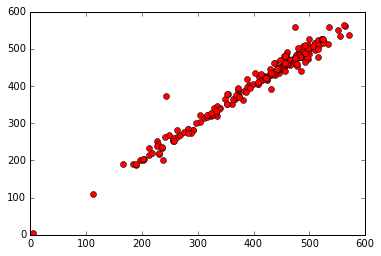

In [67]:
plt.plot(test_df_pred2['DEPT'],test_df_pred2['Pick'], 'ro')

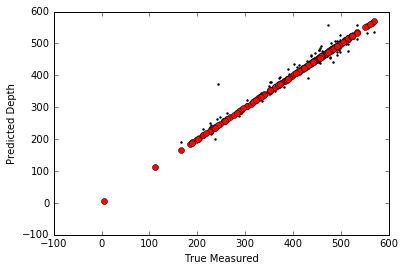

In [68]:
plt.scatter(test_df_pred2['DEPT'],test_df_pred2['Pick'], s=2)
plt.plot(test_df_pred2['DEPT'],test_df_pred2['DEPT'], 'ro')
#plt.plot([Y_all.min(), Y_all.max()], [Y_all.min(), Y_all.max()], 'k--', lw=2)
plt.xlabel('True Measured')
plt.ylabel('Predicted Depth')

In [69]:
import pdvega
import vega

In [70]:
test_df_pred2

CALI  COND     DELT     DEPT   DPHI  DT  DistFrom_NN1_TopDepth        GR  GR_max_11winSize_dirabove  GR_max_11winSize_diraround  GR_max_21winSize_dirabove  GR_max_21winSize_diraround  GR_max_5winSize_dirabove  GR_max_5winSize_diraround  GR_max_7winSize_dirabove  GR_max_7winSize_diraround  GR_mean_11winSize_dirabove  GR_mean_11winSize_diraround  GR_mean_21winSize_dirabove  GR_mean_21winSize_diraround  GR_mean_5winSize_dirabove  GR_mean_5winSize_diraround  GR_mean_7winSize_dirabove  GR_mean_7winSize_diraround  GR_min_11winSize_dirabove  GR_min_11winSize_dirabove_n3  GR_min_11winSize_diraround  GR_min_11winSize_diraround_n3  GR_min_21winSize_dirabove  GR_min_21winSize_dirabove_n3  GR_min_21winSize_diraround  GR_min_21winSize_diraround_n3  GR_min_5winSize_dirabove  GR_min_5winSize_dirabove_n3  GR_min_5winSize_diraround  GR_min_5winSize_diraround_n3  GR_min_7winSize_dirabove  GR_min_7winSize_dirabove_n3  GR_min_7winSize_diraround  GR_min_7winSize_diraround_n3  HorID  HorID_paleoz  \
594  201.983   NaN      NaN  303.948  0.159 NaN                  7.862   68.1830                   140.8850                     75.0300                   140.8850                    140.8850                   68.1830                    72.0060                   91.5640                    72.0060                   91.847091                    68.208909                  108.585429                    82.316143                   64.60680                    68.06420                  69.946857                   67.718143                    62.3160                    136.153000                     62.3160                      72.808667                    62.3160                    139.521000                     62.3160                     136.153000                   62.3160                    65.735333                    63.7790                     70.432667                   62.3160                    78.259000                    62.3160                     71.501667  13000         14000   
721      NaN   NaN      NaN  455.250  0.288 NaN                  6.750   68.6930                    85.4940                     90.3740                    90.1310                    102.4030                   74.9580                    76.8620                   85.4940                    82.1450                   73.887636                    76.373000                   77.338810                    80.150190                   70.45300                    70.88800                  73.955143                   72.513429                    68.6180                     81.277667                     68.6180                      86.589667                    68.6180                     88.403000                     68.6180                      96.852333                   68.6180                    71.651333                    68.6180                     72.376333                   68.6180                    80.126333                    68.6180                     76.762333  13000         14000   
778      NaN   NaN      NaN  469.500  0.193 NaN                 -4.000   89.6440                    89.6440                    114.3600                   111.0020                    114.3600                   89.6440                    96.2350                   89.6440                   104.1100                   80.122909                    90.488909                   90.094714                    91.197524                   82.33520                    90.13760                  78.866000                   90.523857                    68.0200                     88.082667                     68.0200                     109.747333                    68.0200                    109.102333                     68.0200                     112.938333                   68.5590                    88.082667                    86.1080                     92.028000                   68.0200                    88.082667                    78.8690                     96.850000  13000         14000   
699 

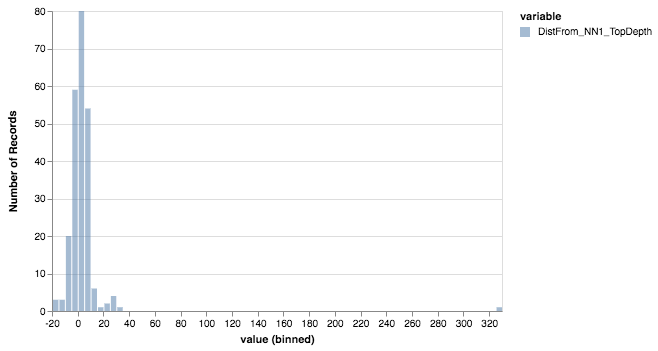

In [79]:
# 'MM_Top_Depth_predBy_NN1thick'
test_df_pred2_TopScratch2 = test_df_pred2[['DistFrom_NN1_TopDepth']]
test_df_pred2_TopScratch2.vgplot.hist(bins=100, alpha=0.5)

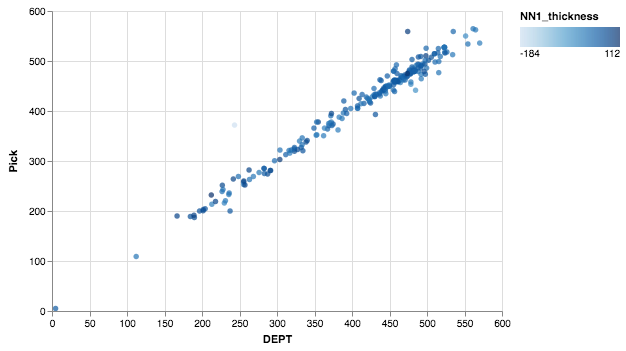

In [74]:
#c='McMurray_Base_DEPTH'
test_df_pred2.vgplot(kind='scatter', x='DEPT', y='Pick',c='NN1_thickness')

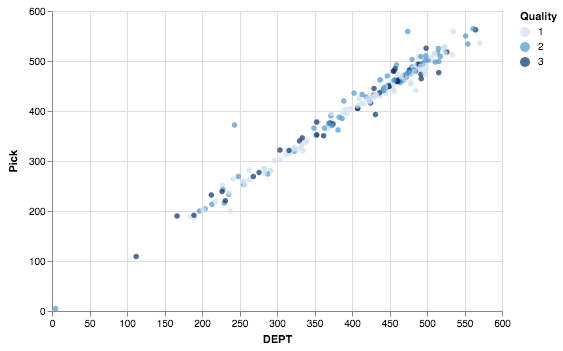

In [73]:
#c='McMurray_Base_DEPTH'
test_df_pred2.vgplot(kind='scatter', x='DEPT', y='Pick',c='Quality')